In [211]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm as cm_mlib
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import scipy
%matplotlib inline
plt.viridis()
from matplotlib import animation, rc, colors
from IPython.display import HTML
from brian2.units import *
import matplotlib as mlib
from scipy import stats
from pprint import pprint as pp
from mpl_toolkits.axes_grid1 import make_axes_locatable
from simulation_statistics.analysis_functions_definitions import *

In [212]:
mlib.rcParams.update({'font.size': 24})
mlib.rcParams.update({'errorbar.capsize': 2})

In [213]:
def distance(x0, x1, grid=np.asarray([16, 16]), type='euclidian'):
    x0 = np.asarray(x0)
    x1 = np.asarray(x1)
    delta = np.abs(x0 - x1)
    delta = np.where(delta > grid * .5, delta - grid, delta)

    if type == 'manhattan':
        return np.abs(delta).sum(axis=-1)
    return np.sqrt((delta ** 2).sum(axis=-1))
def index_to_dist(i1, i2, grid):
    return distance((i1//grid[0], i1%grid[1]),(i2//grid[0], i2%grid[1]), grid=grid, type='euclidian')

In [335]:
# data = np.load("C:/Work/phd/synaptogenesis/east_drifting_grating_default.npz")
# data = np.load("C:/Work/phd/synaptogenesis/east_drifting_grating_default_take_2.npz")
# data = np.load("C:/Work/phd/synaptogenesis/drifting_grating_topographic_map_results_104651_18052018.npz")
# data = np.load("C:/Work/phd/synaptogenesis/drifting_grating_topographic_map_results_114238_18052018.npz")
# data = np.load("C:/Work/phd/synaptogenesis/drifting_grating_topographic_map_results_120831_18052018.npz")


# Off data present

data = np.load("C:/Work/phd/synaptogenesis/drifting_grating_topographic_map_results_132333_18052018.npz")
# data = np.load("C:/Work/phd/synaptogenesis/drifting_grating_topographic_map_results_134858_18052018.npz")
# data = np.load("C:/Work/phd/synaptogenesis/drifting_grating_topographic_map_results_141402_18052018.npz")



In [336]:

simdata = np.array(data['sim_params']).ravel()[0]
grid = simdata['grid']
pp(simdata)
ff_connections = data['ff_connections'][0]
lat_connections = data['lat_connections'][0]
print ff_connections.shape
print lat_connections.shape
init_ff_connections = data['init_ff_connections']
print init_ff_connections.shape
noise_connections = data['noise_connections'][0]
N_layer = grid[0] * grid[1]
n = int(np.sqrt(N_layer))

{'a_minus': 0.0375,
 'a_plus': 0.1,
 'b': 1.2,
 'case': 1,
 'cell_params': {'cm': 20.0,
                 'e_rev_E': 0.0,
                 'e_rev_I': -80.0,
                 'i_offset': 0.0,
                 'tau_m': 20.0,
                 'tau_refrac': 5.0,
                 'tau_syn_E': 5.0,
                 'tau_syn_I': 5.0,
                 'v_reset': -70.0,
                 'v_rest': -70.0,
                 'v_thresh': -50.0},
 'delay': 1,
 'f_base': 5,
 'f_peak': 152.8,
 'f_rew': 10000,
 'g_max': 0.2,
 'grid': array([32, 32]),
 'input_type': 1,
 'lateral_inhibition': False,
 'lesion': 0,
 'p_elim_dep': 0.0245,
 'p_elim_pot': 0.00013600000000000003,
 'p_form_forward': 0.16,
 'p_form_lateral': 1,
 'random_partner': False,
 's_max': 96,
 'sigma_form_forward': 5.0,
 'sigma_form_lateral': 5.0,
 'sigma_stim': 2,
 'simtime': 600000,
 't_minus': 64,
 't_plus': 20.0,
 't_record': 300000,
 't_stim': 20,
 'tau_refrac': 5.0}
(14342L, 4L)
(7374L, 4L)
(0L,)


In [337]:
noise_connections.shape

(12241L, 4L)

In [338]:
final_ff_conn_network = np.ones((N_layer, N_layer)) * np.nan
final_lat_conn_network = np.ones((N_layer, N_layer)) * np.nan
init_ff_conn_network = np.ones((N_layer, N_layer)) * np.nan

ff_num_network = np.zeros((N_layer, N_layer))
lat_num_network = np.zeros((N_layer, N_layer))

init_ff_num_network = np.zeros((N_layer, N_layer))
for source, target, weight, delay in ff_connections:
    if np.isnan(final_ff_conn_network[int(source), int(target)]):
        final_ff_conn_network[int(source), int(target)] = weight
    else:
        final_ff_conn_network[int(source), int(target)] += weight
    ff_num_network[int(source), int(target)] += 1
    
for source, target, weight, delay in noise_connections:
    if np.isnan(final_ff_conn_network[int(source), int(target)]):
        final_ff_conn_network[int(source), int(target)] = weight
    else:
        final_ff_conn_network[int(source), int(target)] += weight
    ff_num_network[int(source), int(target)] += 1

for source, target, weight, delay in lat_connections:
    if np.isnan(final_lat_conn_network[int(source), int(target)]):
        final_lat_conn_network[int(source), int(target)] = weight
    else:
        final_lat_conn_network[int(source), int(target)] += weight
    lat_num_network[int(source), int(target)] += 1

final_ff_conn_field = np.ones(N_layer) * 0
final_lat_conn_field = np.ones(N_layer) * 0

for row in range(final_ff_conn_network.shape[0]):
    final_ff_conn_field += np.roll(
        np.nan_to_num(final_ff_conn_network[row, :]),
        (N_layer // 2 + n//2) - row)
    final_lat_conn_field += np.roll(
        np.nan_to_num(final_lat_conn_network[row, :]),
        (N_layer // 2 + n//2) - row)

final_ff_num_field = np.ones(N_layer) * 0
final_lat_num_field = np.ones(N_layer) * 0

for row in range(ff_num_network.shape[0]):
    final_ff_num_field += np.roll(
        np.nan_to_num(ff_num_network[row, :]),
        (N_layer // 2 + n//2) - row)
    final_lat_num_field += np.roll(
        np.nan_to_num(lat_num_network[row, :]),
        (N_layer // 2 + n//2) - row)

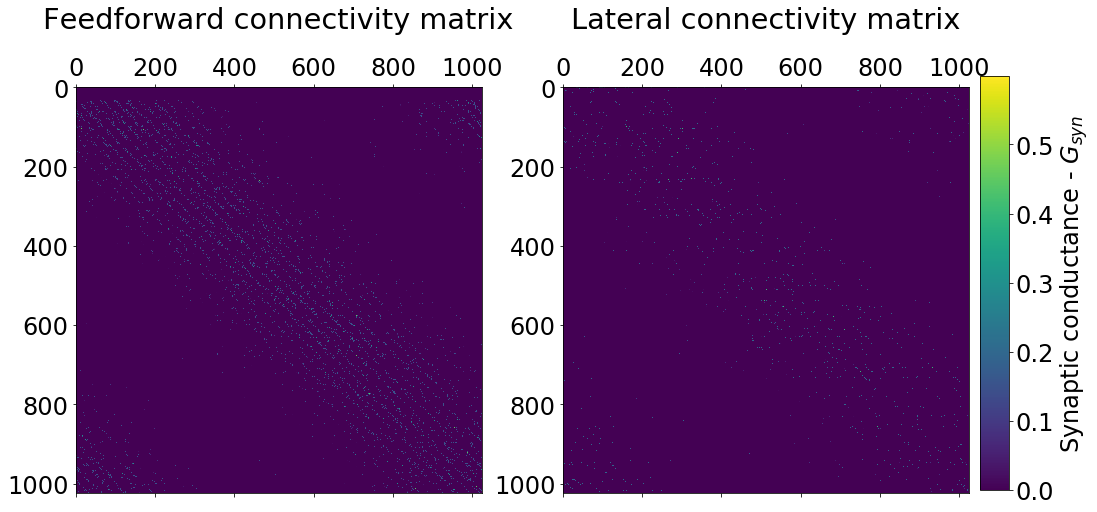

In [339]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), dpi=800)
i = ax1.matshow(np.nan_to_num(final_ff_conn_network))
i2 = ax2.matshow(np.nan_to_num(final_lat_conn_network))
ax1.grid(visible=False)
ax1.set_title("Feedforward connectivity matrix\n")
ax2.set_title("Lateral connectivity matrix\n")
cbar_ax = f.add_axes([.91, 0.155, 0.025, 0.72])
cbar = f.colorbar(i2, cax=cbar_ax)
cbar.set_label("Synaptic conductance - $G_{syn}$")
plt.show()

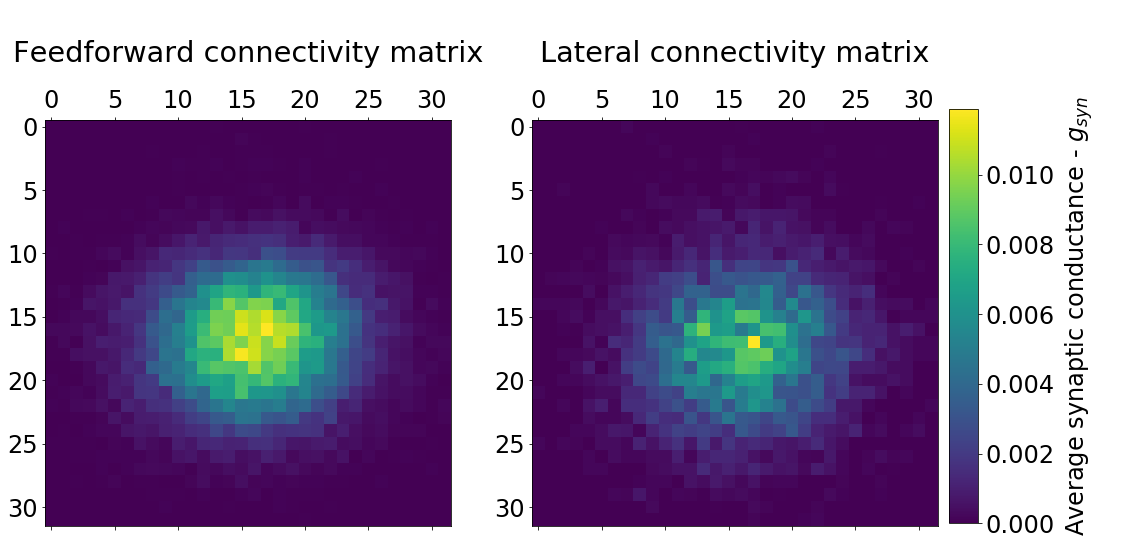

In [340]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), dpi=800)
i = ax1.matshow(final_ff_conn_field.reshape(n,n)/N_layer)
i2 = ax2.matshow(final_lat_conn_field.reshape(n,n)/N_layer)
ax1.grid(visible=False)
ax1.set_title("\nFeedforward connectivity matrix\n")
ax2.set_title("\nLateral connectivity matrix\n")
cbar_ax = f.add_axes([.91, 0.155, 0.025, 0.72])
cbar = f.colorbar(i2, cax=cbar_ax)

norm = colors.Normalize(vmin=np.min([final_ff_conn_field, final_lat_conn_field]), 
                        vmax=np.max([final_ff_conn_field, final_lat_conn_field]))
cbar.set_label("Average synaptic conductance - $g_{syn}$\n")
plt.show()

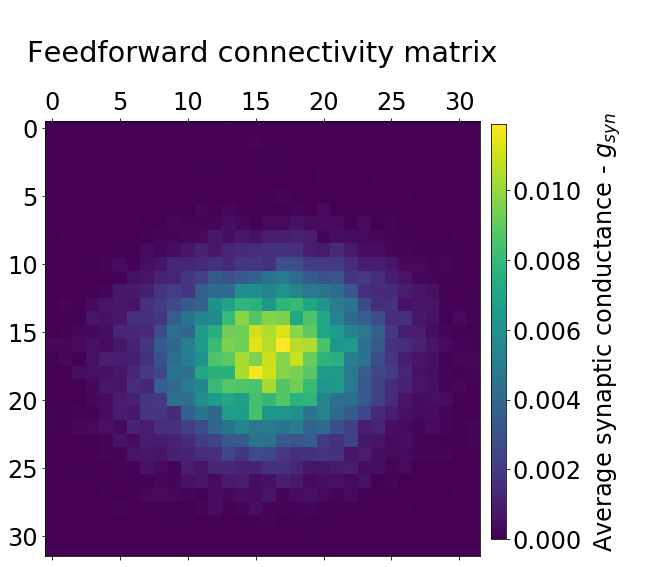

In [341]:
f, (ax1) = plt.subplots(1, 1, figsize=(8, 8), dpi=800)
i = ax1.matshow(final_ff_conn_field.reshape(n,n)/float(N_layer))
ax1.grid(visible=False)
ax1.set_title("\nFeedforward connectivity matrix\n")
cbar_ax = f.add_axes([.91, 0.155, 0.025, 0.72])
cbar = f.colorbar(i2, cax=cbar_ax)

norm = colors.Normalize(vmin=np.min([final_ff_conn_field]), 
                        vmax=np.max([final_ff_conn_field]))
cbar.set_label("Average synaptic conductance - $g_{syn}$\n")
plt.show()

WARNING    C:\WinPython-64bit-2.7.9.4\python-2.7.9.amd64\lib\site-packages\IPython\kernel\__main__.py:2: RuntimeWarning: invalid value encountered in divide
  from IPython.kernel.zmq import kernelapp as app
 [py.warnings]
  from IPython.kernel.zmq import kernelapp as app



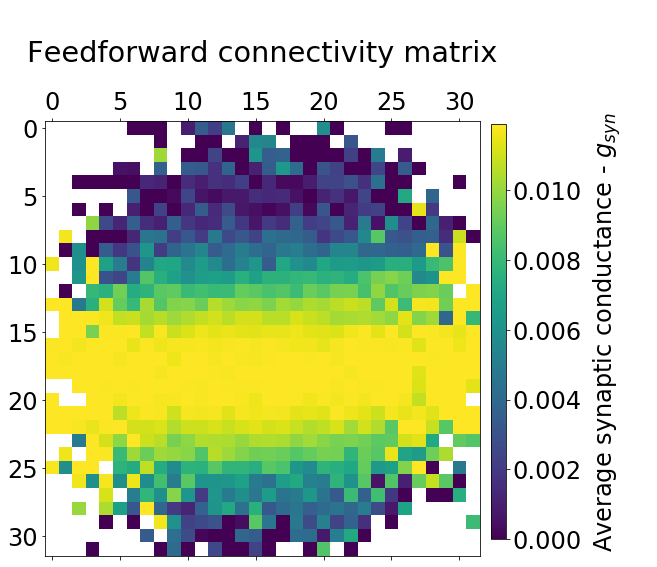

In [342]:
f, (ax1) = plt.subplots(1, 1, figsize=(8, 8), dpi=800)
i = ax1.matshow((final_ff_conn_field/final_ff_num_field).reshape(n,n))
ax1.grid(visible=False)
ax1.set_title("\nFeedforward connectivity matrix\n")
cbar_ax = f.add_axes([.91, 0.155, 0.025, 0.72])
cbar = f.colorbar(i2, cax=cbar_ax)

# norm = colors.Normalize(vmin=np.min([final_ff_conn_field]), 
#                         vmax=np.max([final_ff_conn_field]))
cbar.set_label("Average synaptic conductance - $g_{syn}$\n")
plt.show()

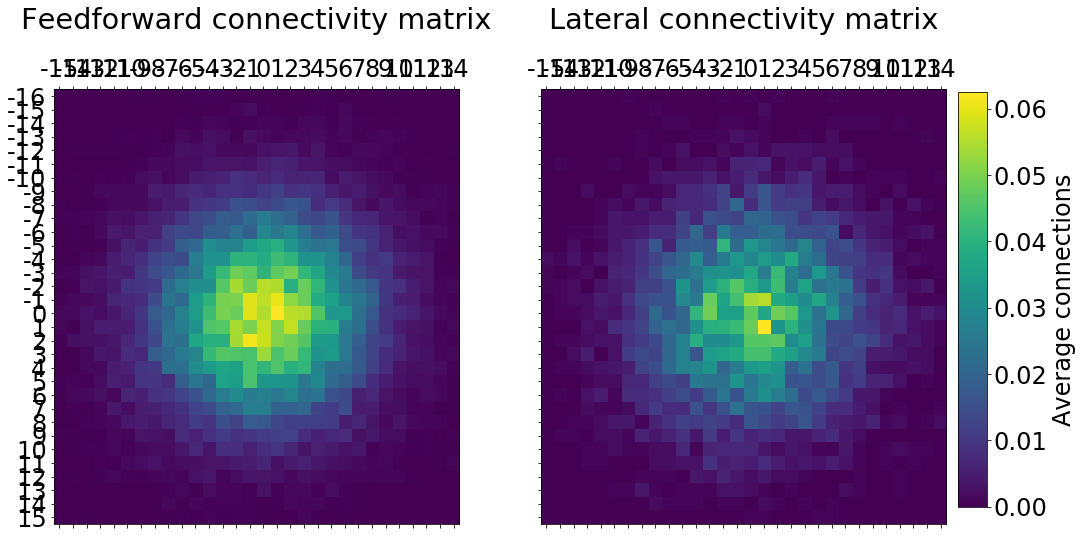

In [343]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), dpi=800, sharey=True)
i = ax1.matshow(final_ff_num_field.reshape(n,n)/N_layer)
i2 = ax2.matshow(final_lat_num_field.reshape(n,n)/N_layer)
ax1.grid(visible=False)
ax1.set_title("Feedforward connectivity matrix\n")
ax2.set_title("Lateral connectivity matrix\n")
cbar_ax = f.add_axes([.91, 0.155, 0.025, 0.72])

ax1.set_xticklabels(np.arange(n) - n//2)
ax1.set_xticks(np.arange(n))


ax2.set_xticklabels(np.arange(n) - n//2)
ax2.set_xticks(np.arange(n))


ax1.set_yticklabels(np.arange(n) - n//2)
ax1.set_yticks(np.arange(n))

norm = colors.Normalize(vmin=np.min([final_ff_num_field, final_lat_num_field])/N_layer*.2, 
                        vmax=np.max([final_ff_num_field, final_lat_num_field])/N_layer*.2)

cbar = f.colorbar(i2, cax=cbar_ax)
cbar.set_label("Average connections")
plt.show()

In [344]:
ff_last = data['final_pre_weights']
off_last = data['noise_connections']
lat_last = data['final_post_weights']
init_ff_weights = data['init_ff_connections']
init_lat_weights = data['init_lat_connections']
ff_init = data['init_ff_connections']
lat_init = data['init_lat_connections']
simdata = np.array(data['sim_params']).ravel()[0]
grid = simdata['grid']
N_layer = grid[0] * grid[1]
n = int(np.sqrt(N_layer))
g_max = simdata['g_max']
s_max = simdata['s_max']
sigma_form_forward = simdata['sigma_form_forward']
sigma_form_lateral = simdata['sigma_form_lateral']
p_form_lateral = simdata['p_form_lateral']
p_form_forward = simdata['p_form_forward']
p_elim_dep = simdata['p_elim_dep']
p_elim_pot = simdata['p_elim_pot']
f_rew = simdata['f_rew']

In [345]:
ff_last = np.concatenate((ff_last, off_last[0]))

In [346]:
# LAT connection bar chart
last_conn, last_weight = list_to_post_pre(ff_last, lat_last,
                                                  s_max, N_layer)



final_fan_in_rec = fan_in(last_conn, last_weight, 'weight',
                          'rec')

final_mean_projection_rec, final_means_and_std_devs_rec, \
final_means_for_plot_rec, final_mean_centred_projection_rec = centre_weights(
    final_fan_in_rec, n)

final_fan_in_rec_rad = \
    radial_sample(final_mean_projection_rec, 1000)

final_fan_in_rec_conn = fan_in(last_conn, last_weight, 'conn',
                               'rec')

final_mean_projection_rec_conn, final_means_and_std_devs_rec_conn, \
final_means_for_plot_rec_conn, final_mean_centred_projection_rec_conn = centre_weights(
    final_fan_in_rec_conn, n)

final_fan_in_rec_rad_conn = \
    radial_sample(final_mean_projection_rec_conn, 1000)
    
## FF connection bar chart


final_fan_in_ff = fan_in(last_conn, last_weight, 'weight',
                         'ff')

final_mean_projection_ff, final_means_and_std_devs_ff, \
final_means_for_plot_ff, final_mean_centred_projection_ff = centre_weights(
    final_fan_in_ff, n)

final_fan_in_ff_rad = \
    radial_sample(final_mean_projection_ff, 1000)

final_fan_in_ff_conn = fan_in(last_conn, last_weight, 'conn',
                              'ff')

final_mean_projection_ff_conn, final_means_and_std_devs_ff_conn, \
final_means_for_plot_ff_conn, final_mean_centred_projection_ff_conn = centre_weights(
    final_fan_in_ff_conn, n)

final_fan_in_ff_rad_conn = \
    radial_sample(final_mean_projection_ff_conn, 1000)

In [347]:
final_fan_in_ff_rad.size

16

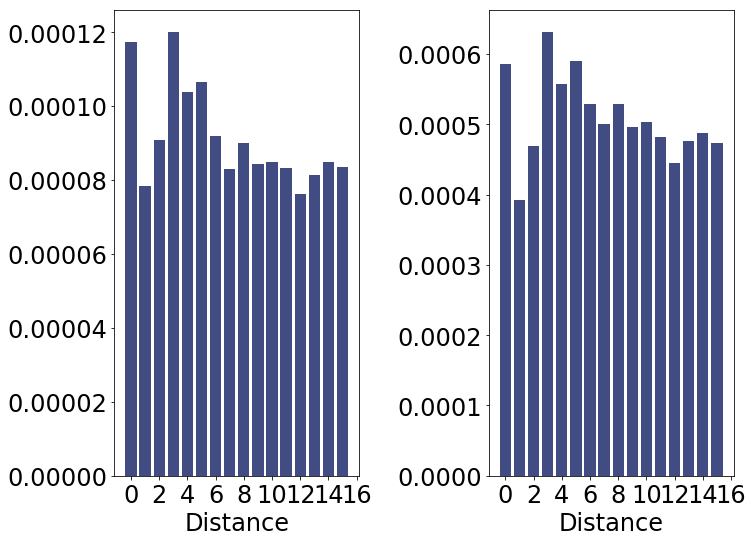

In [348]:
plt.figure(figsize=(16, 8), dpi=800)
plt.subplot(1, 2, 1)
# plt.suptitle("Distance between input and target neurons for lateral connections")
# plt.bar(range(8), init_fan_in_rec_rad, color='#414C82')
# plt.ylim([0, 3.])
# plt.ylim([0, 3])
plt.xticks(range(n))
plt.xlabel("Distance")
plt.ylabel("Weight density (normalised)")
plt.subplot(1, 3, 1)
plt.xticks(np.arange(n)[::2])
# plt.ylim([0, .25])
plt.bar(range(n//2), final_fan_in_ff_rad, color='#414C82')
plt.xlabel("Distance")
plt.subplot(1, 3, 2)
plt.xticks(np.arange(n)[::2])
plt.bar(range(n//2), final_fan_in_ff_rad_conn, color='#414C82')
plt.xlabel("Distance")
# plt.ylim([0, 1.4])
plt.tight_layout()

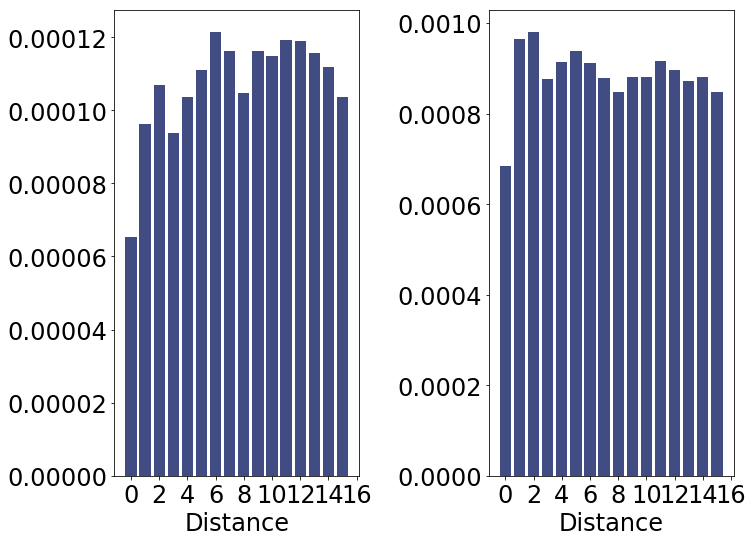

In [349]:
plt.figure(figsize=(16, 8), dpi=800)
plt.subplot(1, 2, 1)
# plt.suptitle("Distance between input and target neurons for lateral connections")
# plt.bar(range(8), init_fan_in_rec_rad, color='#414C82')
# plt.ylim([0, 3.])
# plt.ylim([0, 3])
plt.xticks(range(n))
plt.xlabel("Distance")
plt.ylabel("Weight density (normalised)")
plt.subplot(1, 3, 1)
plt.xticks(np.arange(n)[::2])
# plt.ylim([0, .25])
plt.bar(range(n//2), final_fan_in_rec_rad, color='#414C82')
plt.xlabel("Distance")
plt.subplot(1, 3, 2)
plt.xticks(np.arange(n)[::2])
plt.bar(range(n//2), final_fan_in_rec_rad_conn, color='#414C82')
plt.xlabel("Distance")
# plt.ylim([0, 1.4])
plt.tight_layout()

In [350]:
pol_conn = polar_connectivity(ff_connections, np.array([n,n]))

In [351]:
pol_conn = np.asarray(pol_conn)

In [352]:
pol_conn[:,-1].shape

(14342L,)

In [353]:
pol_conn[:,0] = np.array(pol_conn[:,0])

In [354]:
pol_conn[:,0]

array([ 22.02271555,  24.        ,  25.        , ...,   2.        ,
         1.        ,   0.        ])

In [355]:
pol_conn[:,0].ravel().shape

(14342L,)

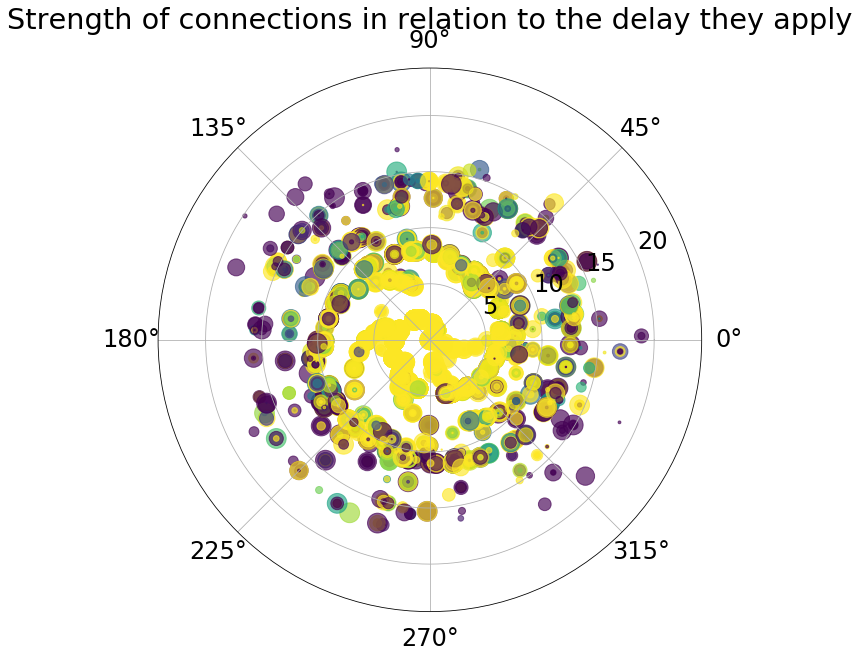

In [356]:
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(111, projection='polar')
# ax.plot(pol_conn[:,0], pol_conn[:,-1], ls="*")
# ax.set_rmax(2)
# ax.set_rticks([0.5, 1, 1.5, 2])  # less radial ticks
# ax.set_rlabel_position(-22.5)  # get radial labels away from plotted line
# ax.grid(True)
N = 150
r = 2*np.random.rand(N)
theta = 2*np.pi*np.random.rand(N)
area = 2 * pol_conn[:,3]**2
# ax = plt.subplot(111, polar=True)
c = plt.scatter(pol_conn[:,0], pol_conn[:,-1], c=pol_conn[:,2], s=area)
c.set_alpha(0.65)

ax.set_title("Strength of connections in relation to the delay they apply", va='bottom')
plt.show()

In [357]:
 pol_conn[:,3]

array([  8.,   5.,  13., ...,   8.,  10.,   2.])

In [358]:
 pol_conn[:,2]

array([ 0.19999695,  0.19999695,  0.19999695, ...,  0.19999695,
        0.19999695,  0.19999695])

In [359]:
pol_conn[:,-1]

array([ 10.04987562,   8.        ,   7.        , ...,   2.        ,
         1.        ,   0.        ])

In [360]:

print np.min( pol_conn[:,0])
print np.max( pol_conn[:,0])
print
print np.min( pol_conn[:,1])
print np.max( pol_conn[:,1])
print
print np.min( pol_conn[:,2])
print np.max( pol_conn[:,2])
print
print np.min( pol_conn[:,3])
print np.max( pol_conn[:,3])
print
print np.min( pol_conn[:,4])
print np.max( pol_conn[:,4])

0.0
43.8406204336

-3.10827165771
3.14159265359

0.0
0.199996948242

1.0
14.0

0.0
19.8494332413


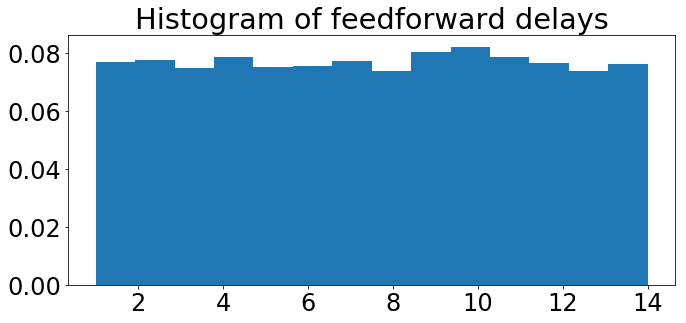

In [361]:
plt.figure(figsize=(10, 5), dpi=600)
plt.hist(pol_conn[:,3], bins=np.unique(pol_conn[:,3]).size, normed=True)
plt.title("Histogram of feedforward delays")
plt.tight_layout()
plt.show()

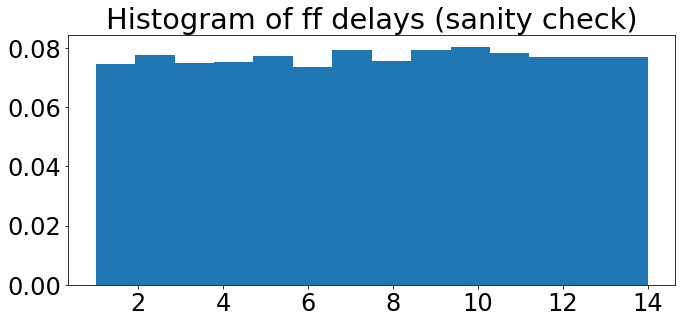

In [362]:
plt.figure(figsize=(10, 5), dpi=600)
plt.hist(ff_last[:,3], bins=np.unique(ff_last[:,3]).size, normed=True)
plt.title("Histogram of ff delays (sanity check)")
plt.tight_layout()
plt.show()

In [363]:
delay_weights={}
for source, target, weight, delay in ff_last:
    if delay in delay_weights.keys():
        delay_weights[delay].append(weight)
    else:
        delay_weights[delay] = [weight]

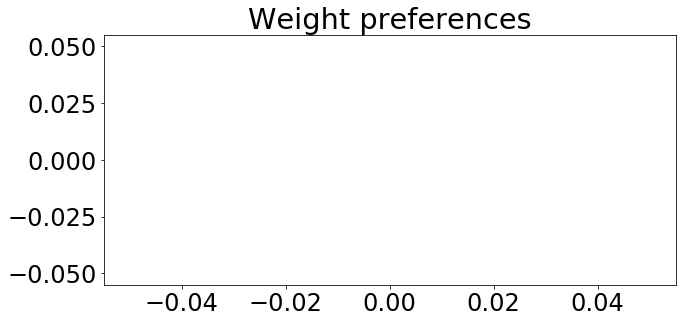

In [364]:
averages = np.zeros(int(np.max(pol_conn[:,3]) - np.min(pol_conn[:,3])+1))
for k in delay_weights.keys():
    averages[int(k)-1] = np.mean(np.asarray(delay_weights[k]))

plt.figure(figsize=(10, 5), dpi=600)
plt.hist(averages,bins=np.arange(np.min(pol_conn[:,3]), np.max(pol_conn[:,3])), normed=True)
plt.title("Weight preferences")
plt.tight_layout()
plt.show()

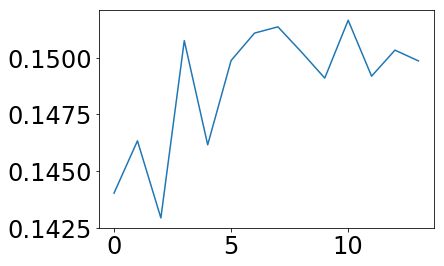

In [365]:
plt.plot(averages)

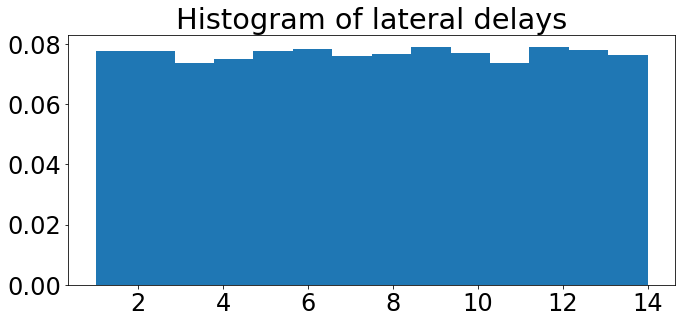

In [366]:
plt.figure(figsize=(10, 5), dpi=600)
plt.hist(lat_last[:,3], bins=np.unique(lat_last[:,3]).size, normed=True)
plt.title("Histogram of lateral delays")
plt.tight_layout()
plt.show()

In [367]:
post_spikes=data['post_spikes']
count_target_spikes = np.zeros(N_layer)
for id, time in post_spikes:
    if time > 290000:
        count_target_spikes[int(id)] += 1    

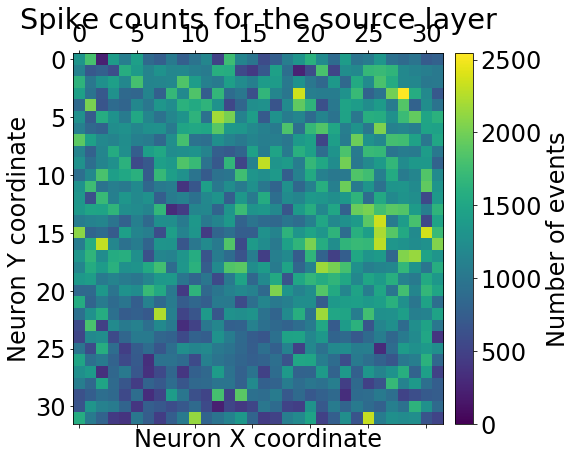

In [368]:
f, (ax1) = plt.subplots(1, 1 ,figsize=(8,8))
i = ax1.matshow(count_target_spikes.reshape(n,n), vmin=0)
ax1.grid(visible=False)
ax1.set_title("Spike counts for the source layer")
ax1.set_xlabel("Neuron X coordinate")
ax1.set_ylabel("Neuron Y coordinate")
# cbar_ax = f.add_axes([.91, 0.155, 0.025, 0.72])
# cbar = f.colorbar(i, cax=cbar_ax)
# cbar.set_label("Events", fontsize=16)
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="3%")
cbar = plt.colorbar(i, cax=cax)
cbar.set_label("Number of events")
plt.tight_layout(.3)